# Mixture of Gaussians Example: Influence Functions for global VI and GVI
We sample data from a student-t distribution with four degrees of freedom and assume it is a Gaussian distribution, hence have misspecification. This is misspecified in itself, and we explore the effect of Outliers to the computed posteriors. The data is contained at a single client.

## Imports

In [1]:
%load_ext autoreload
%autoreload 2

import os
import sys
import logging

module_path = os.path.abspath(os.path.join("../.."))
if module_path not in sys.path:
    sys.path.append(module_path)
    
from pathlib import Path

import math
from __future__ import division
import copy


import torch
import torch.utils.data
import torch.nn as nn
from torch import distributions, nn, optim
from torchvision import transforms, datasets
from scipy.stats import multivariate_normal
import scipy.stats as stats
import numpy as np
import matplotlib
matplotlib.use("pgf")
matplotlib.rcParams.update({
    "pgf.texsystem": "pdflatex",
    'font.family': 'serif',
    'text.usetex': True,
    'pgf.rcfonts': False,
})
import matplotlib.pyplot as plt
import tqdm.auto as tqdm
import pandas as pd

#JITTER = 1e-2

%matplotlib inline
torch.set_default_dtype(torch.float64)

In [2]:
torch.manual_seed(86_960_947)

## Helper Functions

In [3]:
def homogeneous_split(data, partitions):
    rng = np.random.default_rng()
    perm = rng.permutation(len(data))
    
    client_data = []
    for i in range(partitions):
        client_idx = perm[i::partitions]
        client_data.append(data[client_idx])
    
    return client_data

def get_batch(data, length):
    assert length > 0, "Can't use batch of size 0"
    rng = np.random.default_rng()
    perm = rng.permutation(len(data))
    idx_0 = perm[0]
    batch = torch.atleast_2d(data[idx_0])
    l = min(len(data), length)
    
    for i in range(1, l):
        client_idx = perm[i]
        samp = torch.atleast_2d(data[client_idx])
        batch = torch.cat((batch, samp), 0)
    return batch

# Will generate random sized partitions of the data, dependent on the size of the previous partitions
def heterogeneous_split(data, partitions):
    
    l = len(data)
    weights = []
    for i in range(partitions-1):
        w_i = torch.distributions.uniform.Uniform(torch.tensor([1.]), (l-partitions+i)).sample()
        w = torch.floor(w_i)
        weights.append(w.numpy())
        l -= w
    weights.append(l.numpy())
    
    client_data = []
    counter = 0
    for w in weights:
        client_x_n = data[counter:int(counter+w[0])]
        client_data.append(client_x_n)
        counter += w[0]
        counter = int(counter)
        
    return client_data
    
def plot_training(training_array):
    x_vals = np.arange(1, len(training_array)+1)
    plt.figure(figsize=(6,4))
    plt.grid(visible=True)
    plt.plot(x_vals, training_array)
    plt.ylabel('ELBO Loss')
    plt.xlabel('Step')
    plt.show()

In [4]:
# Miscellaneous colour map definitions for visualising different contour plots at the same time

cmap1 = ['lightsalmon', 'navy', 'darkorchid', 'mediumvioletred', 'crimson', 'tomato']
cmap2 = ['teal', 'forestgreen', 'limegreen', 'mediumspringgreen', 'aquamarine', 'mediumturquoise']
cmap3 = ['palevioletred', 'navy', 'darkorchid', 'mediumvioletred', 'crimson', 'tomato', 'lightsalmon']


## Definition of function of mixture of two 2D normals
We assume that the covariance matrix is some coefficient times the identity matrix:

$\mathcal{N}(\pmb{y};\pmb{x}, c\pmb{I})=\frac{1}{2\pi |c\pmb{I}|^{1/2}}\exp \{-\frac{1}{2}(\pmb{y}-\pmb{x})^T(c\pmb{I})^{-1}(\pmb{y}-\pmb{x})\}=\frac{1}{2c\pi} \exp \{-\frac{1}{2c}(\pmb{y}-\pmb{x})^T(\pmb{y}-\pmb{x})\}, \; c\in \mathbb{R}, \pmb{x},\pmb{y}\in \mathbb{R}^2, \pmb{I}\in\mathbb{R}^{2\times2}$

$=\frac{1}{2c\pi}\exp \{-\frac{1}{2c}((y_1-x_1)^2+(y_2-x_2)^2)\}$

In [5]:
def Normal(mean, cov_coef, x, D):
    assert D > 0, "negative dimensional data"
    if D > 2:
        s = np.dot((x-mean),(x-mean))
    elif D == 2:
        if torch.is_tensor(x):
            x = x.squeeze(0).numpy()
        s = (x[0] - mean[0]) ** 2 + (x[1] - mean[1]) ** 2
    else:
        s = (x-mean) ** 2
    return np.exp(-(s/(2 * cov_coef))) / ((np.absolute(2 * cov_coef * np.pi)) ** (D/2))

In [6]:
class Gaussian:
    #Change to log sum exp instead of explicitly evaluating this
    
    def Gaussian(mean, cov, theta):
        assert cov.shape[0] > 0, "Dimensionality specified incorrectly"
        if cov.shape[0] == 1:
            return torch.exp(-(((theta - mean) ** 2)/(2 * cov))) / ((torch.abs(2 * cov * np.pi)) ** 0.5)
        else:
            assert mean.shape[0] == cov.shape[1], "Not the same dimension, multiplication not possible"

            vector = theta-mean
            vector.unsqueeze(-1)

            # (\theta - mean)^T \Sigma ^ {-1} (\theta - mean)        
            part = torch.matmul(vector.unsqueeze(0), torch.linalg.solve(cov, vector.unsqueeze(-1)))

            det = torch.linalg.det(cov) ** 0.5

            coef_ = det * ((np.pi * 2) ** (cov.shape[0] / 2))
            
            coef = coef_ ** -1

            return (coef * torch.exp(- part / 2)).squeeze()
        
    def SphericalGaussian(mean, cov, theta, D):
        assert D > 0, "Negative dimension in spherical Gaussian"
        if D == 1:
            return torch.exp(-(((theta - mean) ** 2)/(2 * cov))) / ((torch.abs(2 * cov * np.pi)) ** 0.5)
        else:
            vector = theta-mean
            vector.unsqueeze(-1)

            # (\theta - mean)^T \Sigma ^ {-1} (\theta - mean)        
            part = torch.matmul(vector.unsqueeze(0), vector.unsqueeze(-1)) / cov

            coef_ = torch.pow(torch.abs(cov * np.pi * 2), (D / 2))

            coef = coef_ ** -1

            return (coef * torch.exp(- part / 2)).squeeze()
    
    def Normal(mean, cov, theta, D):
        if D is None:      
            return Gaussian.Gaussian(mean, cov, theta)
        else:
            return Gaussian.SphericalGaussian(mean, cov, theta, D)
    
    def GaussianMixture(mean_list, cov_list, theta, parameters, D=None):
        ret = 0.
        assert len(mean_list) == len(parameters), "Different list lengths"
        assert len(mean_list) == len(cov_list), "Different list lengths"
        
        param = 0.
        for w in parameters:
            param += w
            
        if param != 1:
            for k in range(len(parameters)):
                w = parameters[k]
                parameters[k] = w / param
                
        if D is None:      
            for i in range(len(parameters)):
                ret += parameters[i] * Gaussian.Gaussian(mean_list[i], cov_list[i], theta)
        else:
            for i in range(len(parameters)):
                ret += parameters[i] * Gaussian.SphericalGaussian(mean_list[i], cov_list[i], theta, D)
            
        return ret
    
    def SampleFromMixture(mean_list, cov_list, parameters, num_samples, include_mean=False):
        
        param = 0.
        for w in parameters:
            param += w
            
        if param != 1:
            for k in range(len(parameters)):
                w = parameters[k]
                parameters[k] = w / param
        
        sample_nums = torch.distributions.multinomial.Multinomial(num_samples, parameters).sample()
        component_sample_num = sample_nums.numpy()
        samples = torch.tensor([])
        mean = torch.zeros_like(mean_list[0])
        
        for i in range(len(parameters)):
            if cov_list[i].shape[0] > 1:    
                m_i = torch.distributions.multivariate_normal.MultivariateNormal(mean_list[i],
                                                                                 covariance_matrix=cov_list[i])
            else:
                m_i = torch.distributions.normal.Normal(mean_list[i],cov_list[i])
            
            if include_mean:
                mean = m_i.mean(dim=0)
                
            sample = m_i.sample((int(component_sample_num[i]),))
            samples = torch.cat((samples, sample), 0)
        if include_mean:     
            return samples, mean
        else:
            return samples
    
    def HeterogenousSampleMix(mean_list, cov_list, parameters, num_samples):
        
        param = 0.
        for w in parameters:
            param += w
            
        if param != 1:
            for k in range(len(parameters)):
                w = parameters[k]
                parameters[k] = w / param
        
        sample_nums = torch.distributions.multinomial.Multinomial(num_samples, 
                                                                           parameters).sample()
        component_sample_num = sample_nums.numpy()
        
        client_data =[]
        for i in range(len(parameters)):
            if cov_list[i].shape[0] > 1:    
                m_i = torch.distributions.multivariate_normal.MultivariateNormal(mean_list[i],
                                                                                 covariance_matrix=cov_list[i])
            else:
                m_i = torch.distributions.normal.Normal(mean_list[i],cov_list[i])
            
            sample = m_i.sample((int(component_sample_num[i]),))
            client_data.append(sample)
                
        return client_data
        

### Applying the mixture of Normals

In [7]:
def Mixture(x, w, mean_1, cov_coef_1, mean_2, cov_coef_2, D):
    return (1 - w) * Normal(mean_1, cov_coef_1, x, D) + w * Normal(mean_2, cov_coef_2, x, D)

### One Dimensional Case of probability distributions

In [8]:
def Normal1d(mean, var, x):
    return np.exp(-((x-mean) ** 2)/(2 * var))/ ((np.absolute(2 * var * np.pi)) ** 0.5)

def Mix(x, w, m_1, var_1, m_2, var_2):
    return (1-w)* Normal1d(m_1, var_1, x) + w * Normal1d(m_2, var_2, x)

## Partitioned Variational Inference for the Clutter Problem

We initialize the approximating distributions as in the EP algorithm, we repeat this here for clarity:
The problem is formulated as follows:

The true likelihood and assumed prior are given below:

$p(\pmb{x}|\pmb{\theta})=(1-w)\mathcal{N}(\pmb{x}|\pmb{\theta}, \pmb{I}_d)+w\mathcal{N}(\pmb{x}|\pmb{0}, a\pmb{I}_d) \\
\pi(\pmb{\theta})=\mathcal{N}(\pmb{\theta}|\pmb{0}, b\pmb{I}_d)$

Over N observation we get the joint distribution of data $\mathcal{D}= \{\pmb{x}_1,...,\pmb{x}_N\}$:

$p(\mathcal{D},\pmb{\theta})=p(\pmb{\theta})\prod_{k=1}^Np(\pmb{x}_k|\pmb{\theta})$

We select approximation 

$q(\pmb{\theta}):=\mathcal{N}(\pmb{\theta}|\pmb{m}, v\pmb{I}_d)$,

with approximating factors --- not true distributions --- $t_n(\pmb{\theta})$:

$t_n(\pmb{\theta}):=s_n \exp \{-\frac{1}{2v_n}(\pmb{\theta}-\pmb{m}_n)^T(\pmb{\theta}-\pmb{m}_n)\},\; n\in [M],\; t_0(\pmb{\theta})=p(\pmb{\theta})$

Such that we have:

$q(\pmb{\theta})=\pi(\pmb{\theta})\prod_{n=1}^Mt_n(\pmb{\theta})$

The PVI algorithm, stated in Algorithm ... in my paper reduces to the following:
### PVI Algorithm Initialization:
We initialize $q(\pmb{\theta})=p(\pmb{\theta})$ by setting $t_i(\pmb{\theta})=1, \; \forall i\in 1,...,M$

We initialize this through setting $s_n=1$ where we are setting $v_n=\infty\implies v_n^{-1}=0$, and $\pmb{m}_n=\pmb{0}$. Each client has one datapoint in this experiment, we have 100 datapoints therefore 100 clients. 

For each iteration $i$ until convergence do:

For each client $n\in{1,...,M}$, do:

### Step 1

$q^{new}(\pmb{\theta})=\mathrm{arg\, max}_{q\in\mathcal{Q}}\int \log \frac{q^{(i-1)}(\pmb{\theta})p(\pmb{y}_n|\pmb{\theta})}{t_n^{(i-1)}(\pmb{\theta})q(\pmb{\theta})}dq(\pmb{\theta}) = 
\mathrm{arg\, min}_{q\in\mathcal{Q}}\mathrm{KL}\bigl(q(\pmb{\theta})\big|\big|\frac{1}{Z_n}\frac{q^{(i-1)}(\pmb{\theta})}{t_n^{(i-1)}(\pmb{\theta})}p(\pmb{y}_n|\pmb{\theta})\bigr), Z_n=\int\frac{q^{(i-1)}(\pmb{\theta})}{t_n^{(i-1)}(\pmb{\theta})}p(\pmb{y}_n|\pmb{\theta})d\pmb{\theta}$

$=\mathrm{arg\,max}_{q\in\mathcal{Q}} \Big\{ \sum_{k\neq \{0,n\}}^N\mathbb{E}_{q(\pmb{\theta})}\big[\log t_k^{(i-1)}(\pmb{\theta})\big]+\sum_{j\in n}\mathbb{E}_{q(\pmb{\theta})}\big[ \log p(\pmb{y}_{n_k}|\pmb{\theta}) \big]  - \mathrm{KL}\bigl(q(\pmb{\theta})\big|\big|\pi(\pmb{\theta})\bigr)\Big\}
$

$ =\mathrm{arg\,min}_{q\in\mathcal{Q}} \Big\{\mathrm{KL}\bigl(q(\pmb{\theta})\big|\big|q^{\backslash n}(\pmb{\theta})\bigr) -\sum_{j\in n}\mathbb{E}_{q(\pmb{\theta})}\big[ \log p(\pmb{y}_{n_j}|\pmb{\theta}) \big] \Big\}
$
### Step 2

Update $t_n(\pmb{\theta})$:

$t^{(i)}_n(\pmb{\theta})\propto \frac{q^{new}(\pmb{\theta})}{q^{(i-1)}(\pmb{\theta})}t^{(i-1)}_n(\pmb{\theta})$

and pass $\Delta_n(\pmb{\theta}) = \frac{t^{(i)}_n(\pmb{\theta})}{t^{(i-1)}_n(\pmb{\theta})}$ to the server.

### Step 3

At the server, update the global approximate likelihood $q^{(i)}(\pmb{\theta})$:

$q^{(i)}(\pmb{\theta})=q^{(i-1)}(\pmb{\theta})\Delta_n(\pmb{\theta})$

#### KLD between two Multivariate Gaussians
The KLD between two $d$-dimensional Multivariate Gaussians $q(\theta)\sim \mathcal{N}(\mu,\Sigma)$ and $p(\theta)\sim\mathcal{N}(\eta,\Lambda)$ is defined as follows:

$\mathrm{KLD}(q(\theta)||p(\theta))= \frac{1}{2}\bigl((\eta-\mu)^\top\Lambda^{-1}(\eta-\mu)+\mathrm{tr}(\Lambda^{-1}\Sigma)+\log \frac{|\Lambda|}{|\Sigma|}-d\bigr)
$

Which, in the case of spherical Gaussians, i.e. $q(\theta)\sim \mathcal{N}(\mu,\alpha\mathrm{I}_d)$ and $p(\theta)\sim\mathcal{N}(\eta,\beta\mathrm{I}_d)$, redused to the following:

$\mathrm{KLD}(q(\theta)||p(\theta))= \frac{1}{2}\bigl(\frac{1}{\beta}(\eta-\mu)^\top(\eta-\mu) +d\frac{\alpha}{\beta}-d\log\frac{\alpha}{\beta} -d\bigr)
$

#### The Alpha Renyi Divergence between two spherical Gaussians is

$\mathrm{D}_{AR}^{(\alpha)}(q(\theta)||\pi(\theta))= \frac{(\mu-\eta)^\top(\mu-\eta)}{2(\alpha\lambda +(1-\alpha)\sigma)} - \frac{D}{2\alpha(\alpha-1)}\log\frac{\alpha \lambda +(1-\alpha)\sigma}{\sigma^{1-\alpha}\:\lambda^{\alpha}}$

$= \frac{(\mu-\eta)^\top(\mu-\eta)}{2(\alpha\lambda +(1-\alpha)\sigma)} - \frac{D}{2\alpha(\alpha-1)}(\log (\alpha \lambda +(1-\alpha)\sigma) - \log (\sigma^{1-\alpha}\:\lambda^{\alpha}))$

$= \frac{(\mu-\eta)^\top(\mu-\eta)}{2(\alpha\lambda +(1-\alpha)\sigma)} + \frac{D}{2\alpha(\alpha-1)}(\log (\sigma^{1-\alpha}\:\lambda^{\alpha})-\log (\alpha \lambda +(1-\alpha)\sigma))$

$= \frac{(\mu-\eta)^\top(\mu-\eta)}{2(\alpha\lambda +(1-\alpha)\sigma)} - \frac{D}{2\alpha}\log (\sigma) + \frac{D}{2(\alpha-1)}\log(\lambda)-\frac{D}{2\alpha(\alpha-1)}\log (\alpha \lambda +(1-\alpha)\sigma))$

In [15]:
def Divergence(q_original, p_likelihood, client, parameters):
    
    div = parameters["Divergence"]
    
    q_approximation = copy.deepcopy(q_original)
    
    if div == "KLD":
        print("Not implemented")
    elif div == "Alpha":
        print("Not implemented")
    elif div == "AR":
        print("Not implemented")
    
    return None  

def kl_gaussians(loc_1, loc_2, cov_1, cov_2):
        # Compute KL(p||q)= E_p(x)[log p(x) - log q(x)]
    assert loc_1.shape == loc_2.shape, "Not same dimension of means"
    assert cov_1.shape == cov_2.shape, "Not same Cov Matrix dimension"
    assert cov_1.shape[0] == cov_1.shape[1], "Not square matrix"

    d = cov_1.shape[0]
    diff = loc_2 - loc_1
    part_1 = torch.matmul(diff.unsqueeze(0), torch.linalg.solve(cov_2, diff.unsqueeze(-1))).squeeze()
    part_2 = torch.trace(torch.linalg.solve(cov_2, cov_1)).squeeze()
    part_3 = (torch.log(torch.linalg.det(cov_2)) - torch.log(torch.linalg.det(cov_1))).squeeze()

    #print(part_1, part_2, part_3, d)

    return (part_1 + part_2 + part_3 - d) / 2
    
def kl_spherical_gaussian(loc_1, loc_2, cov_1, cov_2, config):    
    
    diff = loc_2 - loc_1
    
    part_1 = torch.matmul(diff.unsqueeze(0), diff.unsqueeze(-1)).squeeze() / cov_2
    
    part_2 = config["D"] * cov_1 / cov_2
    
    part_3 = config["D"] * torch.log(torch.abs(cov_1) / torch.abs(cov_2))
    
    return (part_1 + part_2 - part_3 - config["D"]) / 2
    
def alpha_renyi(loc_1, loc_2, cov_1, cov_2, config):
    
    alpha = config["alpha"]
    
    diff = loc_2 - loc_1
    
    lin = (alpha * cov_2) + ((1 - alpha) * cov_1)
    
    part_1 = torch.matmul(diff.unsqueeze(0), torch.linalg.solve(lin, diff.unsqueeze(-1))).squeeze()
    
    part_2 = torch.log(torch.linalg.det(lin)).squeeze() / (alpha * (alpha - 1))
    
    part_3 = torch.log(torch.linalg.det(cov_1)).squeeze() / alpha
    
    part_4 = torch.log(torch.linalg.det(cov_2)).squeeze() / (1 - alpha)
    
    return (part_1 - part_2 - part_3 - part_4) / 2
    
def alpha_renyi_spherical(loc_1, loc_2, var_1, var_2, config):
    
    diff = loc_1 - loc_2
    
    part_1_ = torch.matmul(diff.unsqueeze(0), diff.unsqueeze(-1)).squeeze()
    
    lin = (config["alpha"] * var_2 + (1 - config["alpha"]) * var_1)
    
    part_1 = part_1_ / (2 * lin)
    
    coef_1 = config["D"] / (2 * config["alpha"])
    
    coef_2 = config["D"] / (2 * (config["alpha"] - 1))
    
    coef_3 = config["D"] / (2 * config["alpha"] * (config["alpha"] - 1))
    
    part_2 = coef_1 * torch.log(var_1)
    
    part_3 = coef_2 * torch.log(var_2)
    
    part_4 = coef_3 * torch.log(lin)
    
    return part_1 - part_2 + part_3 - part_4

def gamma_spherical(loc_1, loc_2, var_1, var_2, config):
    
    var_1 = torch.abs(var_1)
    var_2 = torch.abs(var_2)
    
    D = config["D"]
    gamma = config["gamma"]
    
    diff = loc_1 - loc_2
    part_1_ = torch.matmul(diff.unsqueeze(0), diff.unsqueeze(-1)).squeeze()
    lin = (var_2 + (gamma - 1) * var_1)
    part_1 = (part_1_ / (2 * lin)).squeeze()
    
    part_2 = (D / (2*gamma - 2)) * torch.log(lin).squeeze()
    
    part_3 = (D / (gamma -1)) * torch.log(var_1).squeeze()
    
    #Only parts 1-3 are relevant for optimisation but taking out the constants might make convergence metrics
    #have different numbers that the ELBO converges to
    
    part_4 = (gamma/(gamma-1))*torch.log(torch.tensor(2*np.pi))
    
    part_5 = ((D*gamma)/(2*gamma - 2))*torch.log(var_2).squeeze()
    
    part_6 = (D/2)*torch.log(torch.tensor(2*np.pi)).squeeze()
    
    part_7 = (D/(2*gamma - 2))*torch.log(torch.tensor(gamma)).squeeze()
    
    const = part_6 - part_7 - part_5 - part_4
    #const = 0.
    
    return part_1 + part_2 + part_3 + const
    
def FisherRao_normals(mu_1, sigma_1_sq, mu_2, sigma_2_sq):
    sigma_1 = sigma_1_sq ** 0.5
    sigma_2 = sigma_2_sq ** 0.5
    
    diff_mu = (mu_2-mu_1) ** 2
    neg_sigma = (sigma_2-sigma_1) ** 2
    pos_sigma = (sigma_2+sigma_1) ** 2
    numerator = diff_mu + 2*neg_sigma
    denominator = diff_mu + 2*pos_sigma
    Delta = (numerator / denominator) ** 0.5
    
    frac = (1 + Delta) / (1-Delta)
    
    FR = (2 ** 0.5) * (frac.log())
    
    return FR

In [16]:
def PartitionedVariationalInference(q_global, clients, parameters, is_1d=False, minibatch=False, different_loss=False):
    # Implementation of Partitioned Variational Inference for Federated Learning (Bui et al. 2018, Ashman et al. 2022)
    
    # Initialization:
    
    D = parameters["D"]
    
    if parameters["Divergence"] != "AR":
        alpha = None
    else:
        alpha = parameters["alpha"]
    if parameters["Divergence"] != "G":
            gamma = None
    else:
        gamma = parameters["gamma"]
        
    if minibatch:
        batchsize = parameters["batch_size"]
    else:
        batchsize = np.inf
        
    if different_loss:
        loss = parameters["loss"]
    else:
        loss = None
        
    config = {
        "D": D,
        "epochs": parameters["Epochs"], 
        "samples": parameters["samples"],
        "lr_scheduler_params": {"lr_lambda": lambda epoch: 1.0},
        "optim_epochs": parameters["optim_epochs"],
        "is_1d": is_1d,
        "alpha": alpha,
        "gamma": gamma,
        "early_stopping": False,
        "minibatch": minibatch,
        "batchsize": batchsize,
        "loss": loss
    }
        
    print("Starting global q: ", q_global)
    
    for i in range(config["epochs"]):
    
        print("===========================================")
        print(f"Iteration {i+1}:")
        for n in range(len(clients)):
            q_global, t_new = Client.update_q(clients[n], q_global, parameters, config)
            
            clients[n]["mean"] = t_new["mean"]
            clients[n]["variance"] = t_new["variance"]
            clients[n]["variance_inverse"] = t_new["variance_inverse"]
            clients[n]["iteration"] += 1
            

        print("New global q: \n loc: ", q_global["loc"], "\n var: ", q_global["var"])
            
    return q_global, clients
    

In [17]:
def SynchronousPVI(q_global, clients, parameters, is_1d=False, minibatch=False, different_loss=False):
    # Implementation of Partitioned Variational Inference for Federated Learning (Bui et al. 2018, Ashman et al. 2022)
    
    # Initialization:
    
    D = parameters["D"]
    
    if parameters["Divergence"] != "AR":
        alpha = None
    else:
        alpha = parameters["alpha"]
    if parameters["Divergence"] != "G":
            gamma = None
    else:
        gamma = parameters["gamma"]
        
    if minibatch:
        batchsize = parameters["batch_size"]
    else:
        batchsize = np.inf
    
    if different_loss:
        loss = parameters["loss"]
    else:
        loss = None
        
    config = {
        "D": D,
        "epochs": parameters["Epochs"], 
        "samples": parameters["samples"],
        "lr_scheduler_params": {"lr_lambda": lambda epoch: 1.0},
        "optim_epochs": parameters["optim_epochs"],
        "is_1d": is_1d,
        "alpha": alpha,
        "gamma": gamma,
        "early_stopping": False,
        "minibatch": minibatch,
        "batchsize": batchsize,
        "loss": loss
    }
        
    print("Starting global q: ", q_global)
    
    for i in range(config["epochs"]):
    
        print("===========================================")
        print(f"Iteration {i+1}:")
        elbo_i = 0.
        
        q_global_list = []
        for n in range(len(clients)):
            temp = copy.deepcopy(q_global)
            q_global_list.append(temp)
            
        for n in range(len(clients)):
            print(f"Client {n}")
            q_new_n, t_new = Client.update_q(clients[n], q_global_list[n], parameters, config)
            clients[n]["mean"] = t_new["mean"]
            clients[n]["variance"] = t_new["variance"]
            clients[n]["variance_inverse"] = t_new["variance_inverse"]
            clients[n]["iteration"] += 1
            
            #Can we simply pass the q_global_list? instead of doing this to the clients?
            #clients[n]["q_n"]["loc"] = q_new_n["loc"].detach()
            #clients[n]["q_n"]["var"] = q_new_n["var"].detach()
            
            elbo_i += q_new_n["metrics"]["elbos"][i]
        
        q_global = aggregate_posteriors(q_global, q_global_list, elbo_i)
        
        print("New global q: \n loc: ", q_global["loc"], "\n var: ", q_global["var"])
        #if config["early_stopping"]:
                #break
            
    return q_global, clients

def aggregate_posteriors(q_global, q_global_list, elbo):    
    M = len(q_global_list)
    
    denom_var_inv = (M-1) * torch.linalg.inv(q_global["var"].detach())
    denom_var = torch.linalg.inv(denom_var_inv)
    
    denom_mean = torch.matmul(denom_var, (M-1) * torch.linalg.solve(
        q_global["var"].detach(), q_global["loc"].detach().unsqueeze(-1)))
    
    numer_var_inv = torch.zeros_like(q_global["var"].detach())
    for q in q_global_list:
        numer_var_inv += torch.linalg.inv(q["var"].detach())
        
    numer_var = torch.linalg.inv(numer_var_inv)
    
    numer_var_mean = torch.linalg.solve(
        q_global_list[0]["var"].detach(), q_global_list[0]["loc"].detach().unsqueeze(-1))
    
    for i in range(1, len(q_global_list)):
        numer_var_mean += torch.linalg.solve(
            q_global_list[i]["var"].detach(), q_global_list[i]["loc"].detach().unsqueeze(-1))
        
    numer_mean = torch.matmul(numer_var, numer_var_mean)
    
    q_new_var_inv = numer_var_inv - denom_var_inv
    
    q_new_var = torch.linalg.inv(q_new_var_inv)
    
    q_new_var_mean = torch.matmul(numer_var_inv, numer_mean) - torch.matmul(denom_var_inv, denom_mean)
    
    q_new_mean = torch.matmul(q_new_var, q_new_var_mean).squeeze(-1)
    
    q_new = copy.deepcopy(q_global)
    
    q_new["metrics"]["elbos"].append(elbo)
    q_new.update({"loc": torch.nn.Parameter(q_new_mean), "var": torch.nn.Parameter(q_new_var)})
    
    return q_new

In [18]:
def AsynchronousPVI(q_global, clients, parameters, is_1d=False, minibatch=False, different_loss=False):
    # Implementation of Partitioned Variational Inference for Federated Learning (Bui et al. 2018, Ashman et al. 2022)
    
    # Initialization:
    
    D = parameters["D"]
    
    if parameters["Divergence"] != "AR":
        alpha = None
    else:
        alpha = parameters["alpha"]
    if parameters["Divergence"] != "G":
            gamma = None
    else:
        gamma = parameters["gamma"]
        
    if minibatch:
        batchsize = parameters["batch_size"]
    else:
        batchsize = np.inf
        
    if different_loss:
        loss = parameters["loss"]
    else:
        loss = None
        
    config = {
        "D": D,
        "epochs": parameters["Epochs"], 
        "samples": parameters["samples"],
        "lr_scheduler_params": {"lr_lambda": lambda epoch: 1.0},
        "optim_epochs": parameters["optim_epochs"],
        "is_1d": is_1d,
        "alpha": alpha,
        "gamma": gamma,
        "early_stopping": False,
        "minibatch": minibatch,
        "batchsize": batchsize,
        "loss": loss
        
    }
        
    print("Starting global q: ", q_global)
    
    for i in range(config["epochs"]):
    
        print("===========================================")
        print(f"Iteration {i}:")
        elbo_i = 0.
        if i > 0:
            for n in range(len(clients)):
                if clients[n]["wait_time"] == 0 or i % clients[n]["wait_time"] == 0:
                    if clients[n]["wait_time"] <= i:
                        q_global = update_q_async(q_global, clients[n])
              
        for n in range(len(clients)):
            if clients[n]["wait_time"] == 0 or i % clients[n]["wait_time"] == 0:
                print(f"Client {n} with wait time: ", clients[n]["wait_time"])
                
                clients[n]["q_old"]["loc"] = q_global["loc"].detach()
                clients[n]["q_old"]["var"] = q_global["var"].detach()
                temp = copy.deepcopy(q_global)
                
                q_new_n, t_new = Client.update_q(clients[n], temp, parameters, config)
                clients[n]["q_new"]["loc"] = q_new_n["loc"].detach()
                clients[n]["q_new"]["var"] = q_new_n["var"].detach()
            
                clients[n]["mean"] = t_new["mean"]
                clients[n]["variance"] = t_new["variance"]
                clients[n]["variance_inverse"] = t_new["variance_inverse"]
                clients[n]["iteration"] += 1


        print("New global q: \n loc: ", q_global["loc"], "\n var: ", q_global["var"])
        #if config["early_stopping"]:
                #break      
    return q_global, clients

#Mixture of Experts calculation for q_m * q^i / q_m^old \propto q^(i+1)
def update_q_async(q_global, client):    
    
    var_inv = (torch.linalg.inv(client["q_new"]["var"]) + torch.linalg.inv(q_global["var"].detach()) 
               - torch.linalg.inv(client["q_old"]["var"]))
    
    q_new_var = torch.linalg.inv(var_inv)
    
    q_new_mean = torch.matmul(q_new_var, (torch.linalg.solve(client["q_new"]["var"], client["q_new"]["loc"].unsqueeze(-1)) 
                              + torch.linalg.solve(q_global["var"].detach(), q_global["loc"].detach().unsqueeze(-1))
                              - torch.linalg.solve(client["q_old"]["var"], client["q_old"]["loc"].unsqueeze(-1)))).squeeze(-1)
    
    q_current = copy.deepcopy(q_global)
    
    q_current.update({"loc": torch.nn.Parameter(q_new_mean), "var": torch.nn.Parameter(q_new_var)})
    
    return q_current

In [57]:
class Client:    
    def get_default_config():
        return {
            "epochs": 20,
            "optimiser": "Adam",
            "optimiser_params": {"lr": 0.05},
            "model_optimiser_params": {},
            "sigma_optimiser_params": {},
            "lr_scheduler": "MultiplicativeLR",
            "lr_scheduler_params": {"lr_lambda": lambda epoch: 1.0},
        }
    
    def update_q(client, q, parameters, config):

        q_new, t_new = Client.gradient_based_update(client, q, parameters, config)
        #print("New Distribution: ", q_new["loc"], q_new["var"])
        return q_new, t_new

    def gradient_based_update(client, q, parameters, config):
        q_old = copy.deepcopy(q)
        q_cav = Client.cavity(q, client)

        print(f"Cavity distribution {q_cav}")
        q_params = list(q.items())
        
        
        q_parameters = [
                        {"params": q["loc"]},
                        {"params": q["var"]}
                    ]    
        
        #print(q_parameters)
        optimiser = torch.optim.Adam(q_parameters, lr=parameters["lr"])
        #print(optimiser)
        
        lr_scheduler = torch.optim.lr_scheduler.MultiplicativeLR(
            optimiser, **config["lr_scheduler_params"])
        
        #epoch_iter = tqdm(
        #    range(config["epochs"]),
        #    desc="Epoch",
        #    leave=True,
        #)
        for i in range(config["optim_epochs"]):
            
            # Calculate the minimization step and iteratively refine the mean and variance parameters
            # Compute argmin(-F(q)) = argmin {KL(q||q_cav) - Sum(E_q[log p(y_k_i | theta)])}
            
            #epoch = defaultdict(lambda: 0.0)
            """if client["iteration"] > 0:
                print(i)
                print(f"q_cav: loc: ",q_cav["loc"], " and var: ",q_cav["var"])
                print(f"Client: loc: ", client["mean"]," var: ", client["variance"], " var_inverse: ", client["variance_inverse"])
                print(f"q current: loc: ", q["loc"].detach(), " and var: ", q["var"].detach())"""
            optimiser.zero_grad()
            
            coef = 1.
            batch = client["x_n"]
            if config["minibatch"]:
                coef = len(client["x_n"]) / config["batchsize"]
                batch = get_batch(client["x_n"], config["batchsize"])
            
            if client["spherical"]:
                if parameters["Divergence"] == "KLD":
                    div = kl_spherical_gaussian(q["loc"], q_cav["loc"], q["var"], q_cav["var"], config)
                elif parameters["Divergence"] == "AR":
                    div = alpha_renyi_spherical(q["loc"], q_cav["loc"], q["var"], q_cav["var"], config)
                elif parameters["Divergence"] == "G":
                    div = gamma_spherical(q["loc"], q_cav["loc"], q["var"], q_cav["var"], config)
                else:
                    print("!!! No Divergence specified !!!")
                    div = 0
            else:
                if parameters["Divergence"] == "KLD":
                    div = kl_gaussians(q["loc"], q_cav["loc"], q["var"], q_cav["var"])
                elif parameters["Divergence"] == "AR":
                    div = alpha_renyi(q["loc"], q_cav["loc"], q["var"], q_cav["var"], config)
                else:
                    print("!!! No Divergence specified !!!")
                    div = 0
            
            if config["is_1d"]:
                if q["var"] > 0:
                    q_dist = torch.distributions.normal.Normal(q["loc"], q["var"])
                else:
                    q_dist = torch.distributions.normal.Normal(q["loc"], torch.abs(q["var"]))                   
            else:
                if client["spherical"]:
                    if q["var"] > 0:
                        q_dist = torch.distributions.multivariate_normal.MultivariateNormal(
                            q["loc"], covariance_matrix=(q["var"] * torch.eye(config["D"])))
                    else:
                        q_dist = torch.distributions.multivariate_normal.MultivariateNormal(
                            q["loc"], covariance_matrix=(torch.abs(q["var"])* torch.eye(config["D"])))
                else:
                    #if parameters["Divergence"] == "KLD":    
                    q_dist = torch.distributions.multivariate_normal.MultivariateNormal(
                            q["loc"], covariance_matrix=q["var"])
                    #else:
                        #q_dist = torch.distributions.multivariate_normal.MultivariateNormal(
                                #q["loc"], covariance_matrix=(q["var"]+ (torch.eye(config["D"]) * JITTER)))
                        
            
            samples = q_dist.rsample((config["samples"],))
            
            if config["loss"] == "beta":
                ll = - Client.betaLoss(client, batch, samples, parameters, config)
            else:
                #if client["noise_m"] == np.inf:
                    #ll = Client.expected_log_likelihood_normal(client, batch, samples, parameters, config)
                #else:
                ll = Client.expected_log_likelihood(client, batch, samples, parameters, config)
            
            ll = ll*coef
            
            ll /= len(samples)
            
            loss = div - ll
            #print(f"Loss term {loss} of divergence {div} and likelihood {ll}")
            #loss = -ll
            #if i == (config["optim_epochs"]-1):
            #    print(f"KL: {kl}, and log-like: {ll}")
            
            loss.backward()
            optimiser.step()
            
            if i == (config["optim_epochs"]-1):
                q["metrics"]["elbos"].append(-loss.item())
                q["metrics"]["kls"].append(div.item())
                #q["metrics"]["lls"].append(ll.item())
                q["metrics"]["lls"].append(0.)

        
        t_new = Client.update_client_t(client, q, q_old)
        lr_scheduler.step()
        return q, t_new
        
    def cavity(q, client):
        
        if client["spherical"]:
            v_bar_n_inverse = q["var"].detach() ** (-1) - client["variance_inverse"]
            v_bar_n = v_bar_n_inverse ** (-1)

            part = (v_bar_n) * client["variance_inverse"] * (q["loc"].detach() - client["mean"])

            m_bar_n = q["loc"].detach() + part
        else:
            v_bar_n_inverse = torch.linalg.inv(q["var"].detach()) - client["variance_inverse"]
            v_bar_n = torch.linalg.inv(v_bar_n_inverse)
            
            part = torch.linalg.solve(q["var"].detach(), q["loc"].detach().unsqueeze(-1)) - torch.matmul(client["variance_inverse"], client["mean"].unsqueeze(-1))
            m_bar_n = torch.linalg.solve(v_bar_n_inverse, part).squeeze(-1)
        return {
            "loc": m_bar_n,
            "var": v_bar_n
        }
    
    def expected_log_likelihood(client, batch, samples, parameters, config):
        ll = 0.
        Dim = None
        if config["is_1d"] or client["spherical"]:
            cov_list = [client["true_v"], client["noise_v"]]
            Dim = parameters["D"] if parameters["D"] > 1 else None
        else:
            cov_list = [client["true_v"], client["noise_v"]]
            
        if type(parameters["w"]) is list:
            params = parameters["w"]
        else:
            params = [(1 - parameters["w"]), parameters["w"]]
            
        for sample in samples:  
            mean_list = [sample, client["noise_m"]]
            for x in batch:
                ll += Gaussian.GaussianMixture(mean_list, cov_list, x, params, Dim).log()
            
        return ll
    
    def expected_log_likelihood_normal(client, batch, samples, parameters, config):
        print("Hello!!!")
        ll = 0.
        Dim = None
        if config["is_1d"] or client["spherical"]:
            Dim = parameters["D"] if parameters["D"] > 1 else None
            
        for sample in samples:  
            for x in batch:
                ll += Gaussian.Normal(sample, client["true_v"], x, Dim).log()
            
        return ll
    
    #Assumes the misspecified loss is Gaussian
    def betaLoss(client, batch, samples, parameters, config):
        #print("Hi form betaLoss")
        L = 0.
        Dim = parameters["D"]
        
        if config["is_1d"] or client["spherical"]:
            det = torch.pow((2 * np.pi * client["misspec_v"]), torch.tensor((Dim / 2) * (parameters["beta_l"]-1)))
            beta = parameters["beta_l"] ** ((Dim / 2) + 1)
            term_2 = (det * beta) ** -1 
            D = Dim
        else:
            det = torch.linalg.det(client["misspec_v"])
            integral_1 = (2 * np.pi) ** ((Dim / 2) * (parameters["beta_l"]-1))
            integral_2 = torch.pow(det, torch.tensor((1 / 2) * (parameters["beta_l"]-1)))
            beta = parameters["beta_l"] ** ((Dim / 2) + 1)           
            term_2 = (integral_1 * integral_2 * beta) ** -1
            D = None
    
        term_2=0
        #print("Term 2: ", term_2)
        bl = 0.
        for sample in samples:  
            for x in batch:
                likely = Gaussian.Normal(sample, client["misspec_v"], x, D)
                
                #print("Likelihood: ", likely)
                term_1 = (torch.pow(likely, torch.tensor((parameters["beta_l"] - 1))) / (parameters["beta_l"] - 1))
                #print("Term 1: ", term_1)
                if math.isnan(term_1):
                    print("======================================================================================")
                    print(f"Nan for point {x} and sample {sample} and likelihood {likely}")
                    print("======================================================================================")
                    term_1 = 0
                bl += term_2 - term_1
        #print("Beta Loss:", bl)
        return bl
    
    #Not used and not updated
    def get_elbo(client, q, q_cav, parameters, config):
        
        batch = client["x_n"]
            
        kl = kl_spherical_gaussians(q["loc"], q_cav["loc"], q["var"], q_cav["var"], config)

        samples = q.rsample((parameters["samples"],))

        ll = 0.
        for sample in samples:
            ll += expected_log_likelihood(client, batch, sample, parameters)

        ll /= len(samples)

        loss = kl - ll
        
        return loss
    
    #We udate t according to the product of experts formula for gaussians
    def update_client_t(client, q, q_old):
        old_var = client["variance"]
        old_var_inv = client["variance_inverse"]
        old_mean = client["mean"]
        
        if client["spherical"] != True:
            Sigma = q["var"].detach()
            Lambda = q_old["var"].detach()
            
            mu = q["loc"].detach().unsqueeze(-1)
            eta = q_old["loc"].detach().unsqueeze(-1)
        
            Sigma_inv = torch.linalg.inv(Sigma)
            Lambda_inv = torch.linalg.inv(Lambda)
            
            variance_inverse = Sigma_inv - Lambda_inv + old_var_inv
            
            variance = torch.linalg.inv(variance_inverse)
            
            mean_ = (torch.linalg.solve(Sigma, mu) - torch.linalg.solve(Lambda, eta) +
                   torch.matmul(old_var_inv, old_mean.unsqueeze(-1)))
            
            mean = torch.matmul(variance, mean_).squeeze(-1)
            
            #print(f"New q: Sigma: {Sigma}, and Sigma_inv: {Sigma_inv}, and loc: {mu}")
            #print(f"Old q: Lambda: {Lambda}, and Lambda_inv: {Lambda_inv}, and loc: {eta}")
            
            if client["require_s_n"]:
                s_n = Client.compute_mult_normaliser(client, q, q_old, variance_inverse, variance, mean)
            else:
                s_n = None
        else:
            variance_inverse = ((q["var"].detach() ** -1) - 
                                (q_old["var"].detach() ** -1) + client["variance_inverse"])
            variance = variance_inverse ** -1
            
            mean = variance * ((q["var"].detach() ** -1) * q["loc"].detach() -
                   (q_old["var"].detach() ** -1) * q_old["loc"].detach() +
                   client["variance_inverse"] * old_mean)
            
            if client["require_s_n"]:
                s_n = Client.compute_normaliser(client, q, q_old, variance_inverse, variance, mean)
            else:
                s_n = None

            
        #print("variance_inverse: ", variance_inverse)
        #print("variance: ", variance)
        #print("mean: ", mean)
        return {
            "mean": mean,
            "variance": variance,
            "variance_inverse": variance_inverse,
            "normaliser": s_n
        }
            
        
    def compute_normaliser(client, q, q_old, variance_inverse, variance, mean):
        s_n = client["normaliser"]
        """Lambda = q_old["var"].detach()
        Sigma = q["var"].detach()
        S = client["variance"]
        S_inv = client["variance_inverse"]
        m = client["mean"]
        mu = q["loc"].detach()
        eta = q_old["loc"].detach()"""
        
        return s_n


    def compute_mult_normaliser(client, q, q_old, variance_inverse, variance, mean):
        return client["normaliser"]
    
    

# Backup Eperiments for Section 4.5
## This file exclusively deals with the case $M=1$ where we have only a single client and therefore perform Variational Inference (VI) and Generalised Variational Inference (GVI)
## Section 4.5.1 Influence function of KL vs ARD vs Beta Loss with ARD
### 1-D case

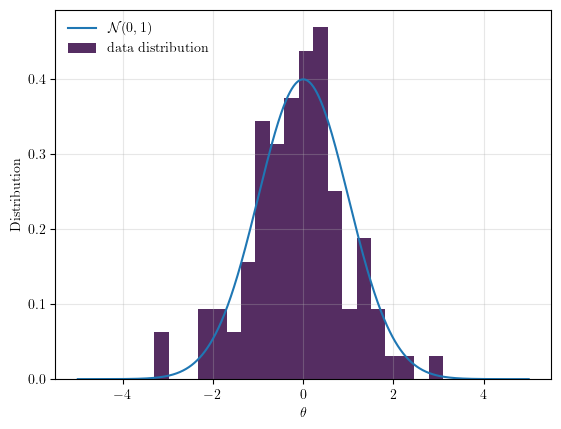

In [20]:
#Generate Data
df = torch.tensor([4])
mean = torch.tensor([0.])
var = torch.tensor([1.])
num_samples = 100

st = torch.distributions.studentT.StudentT(df=4.0, loc=0.0, scale=1.0)
samples_st = st.sample((num_samples,))

samp = samples_st.numpy()
#client_data = homogeneous_split(samples,40)

x = np.linspace(-5, 5, 1000)

plt.plot(x, Normal(0,1,x,1), label=r"$\mathcal{N}(0,1)$")
plt.hist(samp, density=True, bins=20, label="data distribution", color="#552D62")
plt.xlabel(r"$\theta$")
plt.ylabel("Distribution")
plt.legend(loc="upper left", frameon=False)

plt.grid(visible=True, alpha=.3)
#plt.savefig("unimodal_mix_1d.png")
plt.show()

In [89]:
# KL base implementation
parameters_base = {
    "w": torch.tensor(1e-250),
    "a": torch.tensor([1.]),
    "b": torch.tensor([2.5]),
    "D": 1,
    "N": 100,
    "Epochs": 2,
    "Divergence": "KLD",
    "lr": 0.01,
    "samples": 50,
    "optim_epochs": 2000,
    "batch_size": 10   
}

q_global_base_kl = {
    "loc": torch.nn.Parameter(torch.tensor([1.])),
    "var": torch.nn.Parameter(torch.tensor([2.5])),
    "metrics": {
        "elbos": [],
        "kls": [],
        "lls": []
    }
}

clients_base_kl = []
clients_base_kl.append({
    "client_idx": 0,
    "x_n": samples_st,
    "mean": torch.tensor([0.]),
    "variance": torch.tensor([np.inf]),
    "variance_inverse": torch.tensor([0.]),
    "normaliser": torch.tensor(1.),
    "iteration": 0,
    "true_v": parameters_base["a"],
    "noise_m": torch.tensor([0.]),
    "noise_v": parameters_base["a"],
    "spherical": True,
    "require_s_n": False
})

q_new_1d_vi, clients_new_1d_vi = PartitionedVariationalInference(q_global_base_kl, clients_base_kl, parameters_base, is_1d=True, minibatch=False)

Starting global q:  {'loc': Parameter containing:
tensor([1.], requires_grad=True), 'var': Parameter containing:
tensor([2.5000], requires_grad=True), 'metrics': {'elbos': [], 'kls': [], 'lls': []}}
Iteration 1:
Cavity distribution {'loc': tensor([1.]), 'var': tensor([2.5000])}
New global q: 
 loc:  Parameter containing:
tensor([-0.1062], requires_grad=True) 
 var:  Parameter containing:
tensor([0.0701], requires_grad=True)
Iteration 2:
Cavity distribution {'loc': tensor([1.0000]), 'var': tensor([2.5000])}
New global q: 
 loc:  Parameter containing:
tensor([-0.1080], requires_grad=True) 
 var:  Parameter containing:
tensor([0.0698], requires_grad=True)


In [ ]:
data_2 = torch.cat((samples_st, torch.tensor([2.0])))
data_4 = torch.cat((samples_st, torch.tensor([4.0])))
data_6 = torch.cat((samples_st, torch.tensor([6.0])))
data_8 = torch.cat((samples_st, torch.tensor([8.0])))
data_10 = torch.cat((samples_st, torch.tensor([10.0])))
data_12 = torch.cat((samples_st, torch.tensor([12.0])))

In [118]:
data_14 = torch.cat((samples_st, torch.tensor([14.0])))

In [90]:
# KL base implementation
parameters_base_if = {
    "w": torch.tensor(1e-250),
    "a": torch.tensor([1.]),
    "b": torch.tensor([2.5]),
    "D": 1,
    "N": 101,
    "Epochs": 2,
    "Divergence": "KLD",
    "lr": 0.01,
    "samples": 50,
    "optim_epochs": 1500,
    "batch_size": 10   
}

q_global_if_kl = {
    "loc": torch.nn.Parameter(torch.tensor([1.])),
    "var": torch.nn.Parameter(torch.tensor([2.5])),
    "metrics": {
        "elbos": [],
        "kls": [],
        "lls": []
    }
}


clients_if_kl = {
    "client_idx": 0,
    "x_n": None,
    "mean": torch.tensor([0.]),
    "variance": torch.tensor([np.inf]),
    "variance_inverse": torch.tensor([0.]),
    "normaliser": torch.tensor(1.),
    "iteration": 0,
    "true_v": parameters_base["a"],
    "noise_m": torch.tensor([0.]),
    "noise_v": parameters_base["a"],
    "spherical": True,
    "require_s_n": False
}

#q_new_1d_vi, clients_new_1d_vi = PartitionedVariationalInference(q_global_base_kl, clients_base_kl, parameters_base, is_1d=True, minibatch=False)

In [91]:
q_2 = copy.deepcopy(q_global_if_kl)
q_4 = copy.deepcopy(q_global_if_kl)
q_6 = copy.deepcopy(q_global_if_kl)
q_8 = copy.deepcopy(q_global_if_kl)
q_10 = copy.deepcopy(q_global_if_kl)
q_12 = copy.deepcopy(q_global_if_kl)
clients_2 = []
clients_4 = []
clients_6 = []
clients_8 = []
clients_10 = []
clients_12 = []
c2_temp = copy.deepcopy(clients_if_kl)
c2_temp.update({"x_n": data_2})
clients_2.append(c2_temp)
c4_temp = copy.deepcopy(clients_if_kl)
c4_temp.update({"x_n": data_4})
clients_4.append(c4_temp)
c6_temp = copy.deepcopy(clients_if_kl)
c6_temp.update({"x_n": data_6})
clients_6.append(c6_temp)
c8_temp = copy.deepcopy(clients_if_kl)
c8_temp.update({"x_n": data_8})
clients_8.append(c8_temp)
c10_temp = copy.deepcopy(clients_if_kl)
c10_temp.update({"x_n": data_10})
clients_10.append(c10_temp)
c12_temp = copy.deepcopy(clients_if_kl)
c12_temp.update({"x_n": data_12})
clients_12.append(c12_temp)

In [92]:
q_kl_2, _ = PartitionedVariationalInference(q_2, clients_2, parameters_base_if, is_1d=True, minibatch=False)
q_kl_4, _ = PartitionedVariationalInference(q_4, clients_4, parameters_base_if, is_1d=True, minibatch=False)
q_kl_6, _ = PartitionedVariationalInference(q_6, clients_6, parameters_base_if, is_1d=True, minibatch=False)
q_kl_8, _ = PartitionedVariationalInference(q_8, clients_8, parameters_base_if, is_1d=True, minibatch=False)
q_kl_10, _ = PartitionedVariationalInference(q_10, clients_10, parameters_base_if, is_1d=True, minibatch=False)
q_kl_12, _ = PartitionedVariationalInference(q_12, clients_12, parameters_base_if, is_1d=True, minibatch=False)

Starting global q:  {'loc': Parameter containing:
tensor([1.], requires_grad=True), 'var': Parameter containing:
tensor([2.5000], requires_grad=True), 'metrics': {'elbos': [], 'kls': [], 'lls': []}}
Iteration 1:
Cavity distribution {'loc': tensor([1.]), 'var': tensor([2.5000])}
New global q: 
 loc:  Parameter containing:
tensor([-0.0869], requires_grad=True) 
 var:  Parameter containing:
tensor([0.0691], requires_grad=True)
Iteration 2:
Cavity distribution {'loc': tensor([1.0000]), 'var': tensor([2.5000])}
New global q: 
 loc:  Parameter containing:
tensor([-0.0908], requires_grad=True) 
 var:  Parameter containing:
tensor([0.0668], requires_grad=True)
Starting global q:  {'loc': Parameter containing:
tensor([1.], requires_grad=True), 'var': Parameter containing:
tensor([2.5000], requires_grad=True), 'metrics': {'elbos': [], 'kls': [], 'lls': []}}
Iteration 1:
Cavity distribution {'loc': tensor([1.]), 'var': tensor([2.5000])}
New global q: 
 loc:  Parameter containing:
tensor([-0.0673]

In [119]:
q_14 = copy.deepcopy(q_global_if_kl)
clients_14 = []
c14_temp = copy.deepcopy(clients_if_kl)
c14_temp.update({"x_n": data_14})
clients_14.append(c14_temp)
q_kl_14, _ = PartitionedVariationalInference(q_14, clients_14, parameters_base_if, is_1d=True, minibatch=False)

Starting global q:  {'loc': Parameter containing:
tensor([1.], requires_grad=True), 'var': Parameter containing:
tensor([2.5000], requires_grad=True), 'metrics': {'elbos': [], 'kls': [], 'lls': []}}
Iteration 1:
Cavity distribution {'loc': tensor([1.]), 'var': tensor([2.5000])}
New global q: 
 loc:  Parameter containing:
tensor([0.0325], requires_grad=True) 
 var:  Parameter containing:
tensor([0.0686], requires_grad=True)
Iteration 2:
Cavity distribution {'loc': tensor([1.0000]), 'var': tensor([2.5000])}
New global q: 
 loc:  Parameter containing:
tensor([0.0375], requires_grad=True) 
 var:  Parameter containing:
tensor([0.0730], requires_grad=True)


In [121]:
distances = np.array([0,2,4,6,8,10,12,14])
IF = [torch.tensor([0.])]
IF.append(FisherRao_normals(q_new_1d_vi["loc"].detach(),q_new_1d_vi["var"].detach(), q_kl_2["loc"].detach(),q_kl_2["var"].detach()))
IF.append(FisherRao_normals(q_new_1d_vi["loc"].detach(),q_new_1d_vi["var"].detach(), q_kl_4["loc"].detach(),q_kl_4["var"].detach()))
IF.append(FisherRao_normals(q_new_1d_vi["loc"].detach(),q_new_1d_vi["var"].detach(), q_kl_6["loc"].detach(),q_kl_6["var"].detach()))
IF.append(FisherRao_normals(q_new_1d_vi["loc"].detach(),q_new_1d_vi["var"].detach(), q_kl_8["loc"].detach(),q_kl_8["var"].detach()))
IF.append(FisherRao_normals(q_new_1d_vi["loc"].detach(),q_new_1d_vi["var"].detach(), q_kl_10["loc"].detach(),q_kl_10["var"].detach()))
IF.append(FisherRao_normals(q_new_1d_vi["loc"].detach(),q_new_1d_vi["var"].detach(), q_kl_12["loc"].detach(),q_kl_12["var"].detach()))
IF.append(FisherRao_normals(q_new_1d_vi["loc"].detach(),q_new_1d_vi["var"].detach(), q_kl_14["loc"].detach(),q_kl_14["var"].detach()))
IF = torch.tensor(IF)

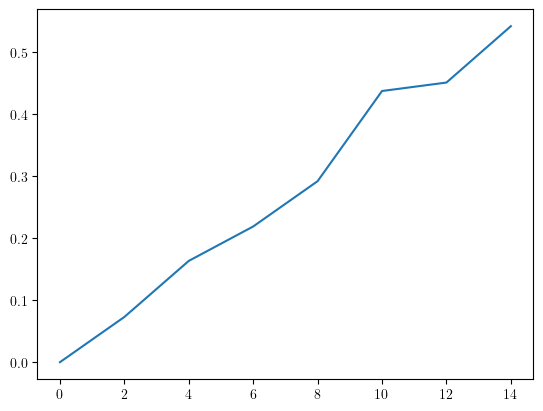

In [122]:
plt.plot(distances, IF.numpy())

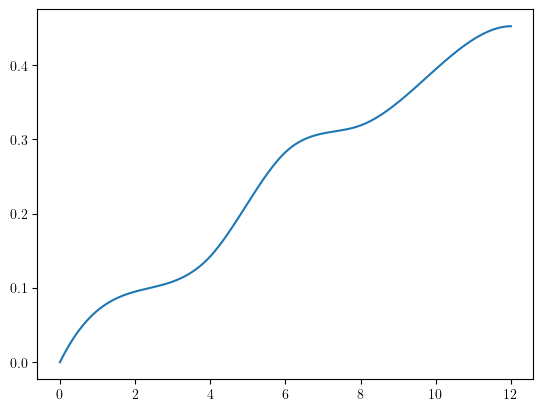

In [84]:
from scipy.interpolate import make_interp_spline, BSpline

# 300 represents number of points to make between T.min and T.max
xnew = np.linspace(distances.min(), distances.max(), 300) 

spl = make_interp_spline(distances, IF.numpy(), k=3)  # type: BSpline
power_smooth = spl(xnew)

plt.plot(xnew, power_smooth)
plt.show()

In [79]:
# alpha-Renyi base implementation
parameters_base_ar = {
    "w": torch.tensor(1e-250),
    "a": torch.tensor([1.]),
    "b": torch.tensor([10.]),
    "D": 1,
    "N": 100,
    "Epochs": 2,
    "Divergence": "AR",
    "lr": 0.01,
    "samples": 50,
    "optim_epochs": 2000,
    "alpha": 0.5
}

q_global_base_ar = {
    "loc": torch.nn.Parameter(torch.tensor([1.])),
    "var": torch.nn.Parameter(torch.tensor([2.5])),
    "metrics": {
        "elbos": [],
        "kls": [],
        "lls": []
    }
}

clients_base_ar = []
clients_base_ar.append({
    "client_idx": 0,
    "x_n": samples_st,
    "mean": torch.tensor([0.]),
    "variance": torch.tensor([np.inf]),
    "variance_inverse": torch.tensor([0.]),
    "normaliser": torch.tensor(1.),
    "iteration": 0,
    "true_v": parameters_base_ar["a"],
    "noise_m": torch.tensor([0.]),
    "noise_v": parameters_base_ar["a"],
    "spherical": True,
    "require_s_n": False
})

q_base_ar, clients_base_ar = PartitionedVariationalInference(q_global_base_ar, clients_base_ar, parameters_base_ar, is_1d=True, minibatch=False)


Starting global q:  {'loc': Parameter containing:
tensor([1.], requires_grad=True), 'var': Parameter containing:
tensor([2.5000], requires_grad=True), 'metrics': {'elbos': [], 'kls': [], 'lls': []}}
Iteration 1:
Cavity distribution {'loc': tensor([1.]), 'var': tensor([2.5000])}
New global q: 
 loc:  Parameter containing:
tensor([-0.1026], requires_grad=True) 
 var:  Parameter containing:
tensor([0.0954], requires_grad=True)
Iteration 2:
Cavity distribution {'loc': tensor([1.0000]), 'var': tensor([2.5000])}
New global q: 
 loc:  Parameter containing:
tensor([-0.1002], requires_grad=True) 
 var:  Parameter containing:
tensor([0.1085], requires_grad=True)


In [80]:
# KL base implementation
parameters_base_if_ar = {
    "w": torch.tensor(1e-250),
    "a": torch.tensor([1.]),
    "b": torch.tensor([10.]),
    "D": 1,
    "N": 101,
    "Epochs": 2,
    "Divergence": "AR",
    "lr": 0.01,
    "samples": 50,
    "optim_epochs": 2000,
    "batch_size": 10,
    "alpha": 0.5 
}

q_global_if_ar = {
    "loc": torch.nn.Parameter(torch.tensor([1.])),
    "var": torch.nn.Parameter(torch.tensor([2.5])),
    "metrics": {
        "elbos": [],
        "kls": [],
        "lls": []
    }
}


clients_if_ar = {
    "client_idx": 0,
    "x_n": None,
    "mean": torch.tensor([0.]),
    "variance": torch.tensor([np.inf]),
    "variance_inverse": torch.tensor([0.]),
    "normaliser": torch.tensor(1.),
    "iteration": 0,
    "true_v": parameters_base_ar["a"],
    "noise_m": torch.tensor([0.]),
    "noise_v": parameters_base_ar["a"],
    "spherical": True,
    "require_s_n": False
}

In [81]:
q_2_ar = copy.deepcopy(q_global_if_ar)
q_4_ar = copy.deepcopy(q_global_if_ar)
q_6_ar = copy.deepcopy(q_global_if_ar)
q_8_ar = copy.deepcopy(q_global_if_ar)
q_10_ar = copy.deepcopy(q_global_if_ar)
q_12_ar = copy.deepcopy(q_global_if_ar)
clients_2_ar = []
clients_4_ar = []
clients_6_ar = []
clients_8_ar = []
clients_10_ar = []
clients_12_ar = []
c2_temp_ar = copy.deepcopy(clients_if_ar)
c2_temp_ar.update({"x_n": data_2})
clients_2_ar.append(c2_temp_ar)
c4_temp_ar = copy.deepcopy(clients_if_ar)
c4_temp_ar.update({"x_n": data_4})
clients_4_ar.append(c4_temp_ar)
c6_temp_ar = copy.deepcopy(clients_if_ar)
c6_temp_ar.update({"x_n": data_6})
clients_6_ar.append(c6_temp_ar)
c8_temp_ar = copy.deepcopy(clients_if_ar)
c8_temp_ar.update({"x_n": data_8})
clients_8_ar.append(c8_temp_ar)
c10_temp_ar = copy.deepcopy(clients_if_ar)
c10_temp_ar.update({"x_n": data_10})
clients_10_ar.append(c10_temp_ar)
c12_temp_ar = copy.deepcopy(clients_if_ar)
c12_temp_ar.update({"x_n": data_12})
clients_12_ar.append(c12_temp_ar)

In [82]:
q_ar_2, _ = PartitionedVariationalInference(q_2_ar, clients_2_ar, parameters_base_if_ar, is_1d=True, minibatch=False)
q_ar_4, _ = PartitionedVariationalInference(q_4_ar, clients_4_ar, parameters_base_if_ar, is_1d=True, minibatch=False)
q_ar_6, _ = PartitionedVariationalInference(q_6_ar, clients_6_ar, parameters_base_if_ar, is_1d=True, minibatch=False)
q_ar_8, _ = PartitionedVariationalInference(q_8_ar, clients_8_ar, parameters_base_if_ar, is_1d=True, minibatch=False)
q_ar_10, _ = PartitionedVariationalInference(q_10_ar, clients_10_ar, parameters_base_if_ar, is_1d=True, minibatch=False)
q_ar_12, _ = PartitionedVariationalInference(q_12_ar, clients_12_ar, parameters_base_if_ar, is_1d=True, minibatch=False)

Starting global q:  {'loc': Parameter containing:
tensor([1.], requires_grad=True), 'var': Parameter containing:
tensor([2.5000], requires_grad=True), 'metrics': {'elbos': [], 'kls': [], 'lls': []}}
Iteration 1:
Cavity distribution {'loc': tensor([1.]), 'var': tensor([2.5000])}
New global q: 
 loc:  Parameter containing:
tensor([-0.0844], requires_grad=True) 
 var:  Parameter containing:
tensor([0.0934], requires_grad=True)
Iteration 2:
Cavity distribution {'loc': tensor([1.0000]), 'var': tensor([2.5000])}
New global q: 
 loc:  Parameter containing:
tensor([-0.0953], requires_grad=True) 
 var:  Parameter containing:
tensor([0.0998], requires_grad=True)
Starting global q:  {'loc': Parameter containing:
tensor([1.], requires_grad=True), 'var': Parameter containing:
tensor([2.5000], requires_grad=True), 'metrics': {'elbos': [], 'kls': [], 'lls': []}}
Iteration 1:
Cavity distribution {'loc': tensor([1.]), 'var': tensor([2.5000])}
New global q: 
 loc:  Parameter containing:
tensor([-0.0596]

In [124]:
q_14_ar = copy.deepcopy(q_global_if_ar)
clients_14_ar = []
c14_temp_ar = copy.deepcopy(clients_if_ar)
c14_temp_ar.update({"x_n": data_14})
clients_14_ar.append(c14_temp_ar)
q_ar_14, _ = PartitionedVariationalInference(q_14_ar, clients_14_ar, parameters_base_if_ar, is_1d=True, minibatch=False)

Starting global q:  {'loc': Parameter containing:
tensor([1.], requires_grad=True), 'var': Parameter containing:
tensor([2.5000], requires_grad=True), 'metrics': {'elbos': [], 'kls': [], 'lls': []}}
Iteration 1:
Cavity distribution {'loc': tensor([1.]), 'var': tensor([2.5000])}
New global q: 
 loc:  Parameter containing:
tensor([0.0373], requires_grad=True) 
 var:  Parameter containing:
tensor([0.0951], requires_grad=True)
Iteration 2:
Cavity distribution {'loc': tensor([1.0000]), 'var': tensor([2.5000])}
New global q: 
 loc:  Parameter containing:
tensor([0.0524], requires_grad=True) 
 var:  Parameter containing:
tensor([0.0987], requires_grad=True)


In [125]:
IF_ar =[torch.tensor(0.)]
IF_ar.append(FisherRao_normals(q_base_ar["loc"].detach(),q_base_ar["var"].detach(), q_ar_2["loc"].detach(),q_ar_2["var"].detach()))
IF_ar.append(FisherRao_normals(q_base_ar["loc"].detach(),q_base_ar["var"].detach(), q_ar_4["loc"].detach(),q_ar_4["var"].detach()))
IF_ar.append(FisherRao_normals(q_base_ar["loc"].detach(),q_base_ar["var"].detach(), q_ar_6["loc"].detach(),q_ar_6["var"].detach()))
IF_ar.append(FisherRao_normals(q_base_ar["loc"].detach(),q_base_ar["var"].detach(), q_ar_8["loc"].detach(),q_ar_8["var"].detach()))
IF_ar.append(FisherRao_normals(q_base_ar["loc"].detach(),q_base_ar["var"].detach(), q_ar_10["loc"].detach(),q_ar_10["var"].detach()))
IF_ar.append(FisherRao_normals(q_base_ar["loc"].detach(),q_base_ar["var"].detach(), q_ar_12["loc"].detach(),q_ar_12["var"].detach()))
IF_ar.append(FisherRao_normals(q_base_ar["loc"].detach(),q_base_ar["var"].detach(), q_ar_14["loc"].detach(),q_ar_14["var"].detach()))
IF_ar = torch.tensor(IF_ar)
print(IF_ar)

tensor([0.0000, 0.0610, 0.1630, 0.2385, 0.2620, 0.3367, 0.3648, 0.4770])


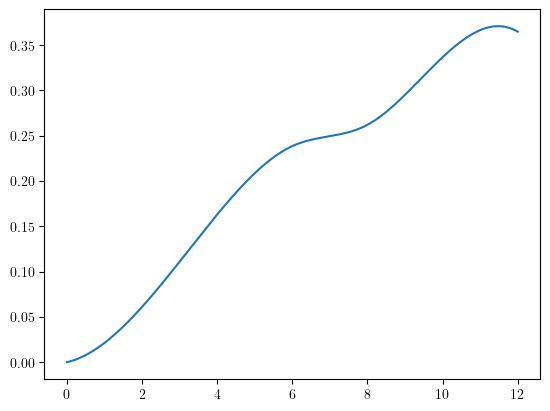

In [84]:
from scipy.interpolate import make_interp_spline, BSpline

# 300 represents number of points to make between T.min and T.max
xnew = np.linspace(distances.min(), distances.max(), 300) 

#spl = make_interp_spline(distances, IF.numpy(), k=3)  # type: BSpline
#power_smooth = spl(xnew)

spl2 = make_interp_spline(distances, IF_ar.numpy(), k=3)  # type: BSpline
power_smooth2 = spl2(xnew)

#plt.plot(xnew, power_smooth)
plt.plot(xnew, power_smooth2)

plt.show()

In [21]:
2.5e-4

0.00025

In [58]:
# Beta Loss base implementation
parameters_base_b = {
    "w": torch.tensor(1e-250),
    "a": torch.tensor([1.]),
    "b": torch.tensor([2.]),
    "D": 1,
    "N": 100,
    "Epochs": 2,
    "Divergence": "AR",
    "lr": 2.5e-3,
    "samples": 50,
    "optim_epochs": 2000,
    "alpha": 0.5,
    "loss": "beta",
    "beta_l": 1.05
}

q_global_base_b = {
    "loc": torch.nn.Parameter(torch.tensor([1.])),
    "var": torch.nn.Parameter(torch.tensor([2.5])),
    "metrics": {
        "elbos": [],
        "kls": [],
        "lls": []
    }
}

clients_base_b = []
#for i in range(num_clients):
clients_base_b.append({
    "client_idx": 0,
    "x_n": samples_st,#_c[i]
    "mean": torch.tensor([0.]),
    "variance": torch.tensor([np.inf]),
    "variance_inverse": torch.tensor([0.]),
    "normaliser": torch.tensor(1.),
    "iteration": 0,
    "misspec_v": parameters_base_b["a"],
    "true_v": parameters_base_b["a"],
    "noise_m": torch.tensor([0.]),
    "noise_v": parameters_base_b["a"],
    "spherical": True,
    "require_s_n": False
})

q_base_b, clients_base_b = PartitionedVariationalInference(q_global_base_b, clients_base_b, parameters_base_b, is_1d=True, different_loss=True)


Starting global q:  {'loc': Parameter containing:
tensor([1.], requires_grad=True), 'var': Parameter containing:
tensor([2.5000], requires_grad=True), 'metrics': {'elbos': [], 'kls': [], 'lls': []}}
Iteration 1:
Cavity distribution {'loc': tensor([1.]), 'var': tensor([2.5000])}
New global q: 
 loc:  Parameter containing:
tensor([-0.0975], requires_grad=True) 
 var:  Parameter containing:
tensor([0.1050], requires_grad=True)
Iteration 2:
Cavity distribution {'loc': tensor([1.0000]), 'var': tensor([2.5000])}
New global q: 
 loc:  Parameter containing:
tensor([-0.1010], requires_grad=True) 
 var:  Parameter containing:
tensor([0.1036], requires_grad=True)


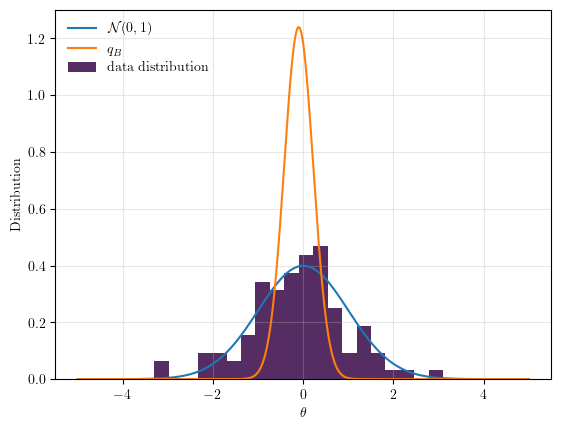

In [59]:
x = np.linspace(-5, 5, 1000)

plt.plot(x, Normal(0,1,x,1), label=r"$\mathcal{N}(0,1)$")
plt.plot(x, Normal(q_base_b["loc"].detach().numpy(),q_base_b["var"].detach().numpy(),x,1), label=r"$q_B$")

plt.hist(samp, density=True, bins=20, label="data distribution", color="#552D62")
plt.xlabel(r"$\theta$")
plt.ylabel("Distribution")
plt.legend(loc="upper left", frameon=False)

plt.grid(visible=True, alpha=.3)
#plt.savefig("unimodal_mix_1d.png")
plt.show()

In [68]:
# KL base implementation
parameters_base_if_b = {
    "w": torch.tensor(1e-250),
    "a": torch.tensor([1.]),
    "b": torch.tensor([10.]),
    "D": 1,
    "N": 101,
    "Epochs": 2,
    "Divergence": "AR",
    "lr": 2.5e-3,
    "samples": 50,
    "optim_epochs": 2000,
    "alpha": 0.5,
    "loss": "beta",
    "beta_l": 1.05
}

q_global_if_b = {
    "loc": torch.nn.Parameter(torch.tensor([1.])),
    "var": torch.nn.Parameter(torch.tensor([2.5])),
    "metrics": {
        "elbos": [],
        "kls": [],
        "lls": []
    }
}


clients_if_b = {
    "client_idx": 0,
    "x_n": None,
    "mean": torch.tensor([0.]),
    "variance": torch.tensor([np.inf]),
    "variance_inverse": torch.tensor([0.]),
    "normaliser": torch.tensor(1.),
    "iteration": 0,
    "misspec_v": parameters_base_b["a"],
    "true_v": parameters_base_b["a"],
    "noise_m": torch.tensor([0.]),
    "noise_v": parameters_base_b["a"],
    "spherical": True,
    "require_s_n": False
}

In [69]:
q_2_b = copy.deepcopy(q_global_if_b)
q_4_b = copy.deepcopy(q_global_if_b)
q_6_b = copy.deepcopy(q_global_if_b)
q_8_b = copy.deepcopy(q_global_if_b)
q_10_b = copy.deepcopy(q_global_if_b)
q_12_b = copy.deepcopy(q_global_if_b)
clients_2_b = []
clients_4_b = []
clients_6_b = []
clients_8_b = []
clients_10_b = []
clients_12_b = []
c2_temp_b = copy.deepcopy(clients_if_b)
c2_temp_b.update({"x_n": data_2})
clients_2_b.append(c2_temp_b)
c4_temp_b = copy.deepcopy(clients_if_b)
c4_temp_b.update({"x_n": data_4})
clients_4_b.append(c4_temp_b)
c6_temp_b = copy.deepcopy(clients_if_b)
c6_temp_b.update({"x_n": data_6})
clients_6_b.append(c6_temp_b)
c8_temp_b = copy.deepcopy(clients_if_b)
c8_temp_b.update({"x_n": data_8})
clients_8_b.append(c8_temp_b)
c10_temp_b = copy.deepcopy(clients_if_b)
c10_temp_b.update({"x_n": data_10})
clients_10_b.append(c10_temp_b)
c12_temp_b = copy.deepcopy(clients_if_b)
c12_temp_b.update({"x_n": data_12})
clients_12_b.append(c12_temp_b)

In [70]:
q_b_2, _ = PartitionedVariationalInference(q_2_b, clients_2_b, parameters_base_if_b, is_1d=True, different_loss=True)
q_b_4, _ = PartitionedVariationalInference(q_4_b, clients_4_b, parameters_base_if_b, is_1d=True, different_loss=True)
q_b_6, _ = PartitionedVariationalInference(q_6_b, clients_6_b, parameters_base_if_b, is_1d=True, different_loss=True)
q_b_8, _ = PartitionedVariationalInference(q_8_b, clients_8_b, parameters_base_if_b, is_1d=True, different_loss=True)
q_b_10, _ = PartitionedVariationalInference(q_10_b, clients_10_b, parameters_base_if_b, is_1d=True, different_loss=True)
q_b_12, _ = PartitionedVariationalInference(q_12_b, clients_12_b, parameters_base_if_b, is_1d=True, different_loss=True)

Starting global q:  {'loc': Parameter containing:
tensor([1.], requires_grad=True), 'var': Parameter containing:
tensor([2.5000], requires_grad=True), 'metrics': {'elbos': [], 'kls': [], 'lls': []}}
Iteration 1:
Cavity distribution {'loc': tensor([1.]), 'var': tensor([2.5000])}
New global q: 
 loc:  Parameter containing:
tensor([-0.0746], requires_grad=True) 
 var:  Parameter containing:
tensor([0.1041], requires_grad=True)
Iteration 2:
Cavity distribution {'loc': tensor([1.0000]), 'var': tensor([2.5000])}
New global q: 
 loc:  Parameter containing:
tensor([-0.0679], requires_grad=True) 
 var:  Parameter containing:
tensor([0.1030], requires_grad=True)
Starting global q:  {'loc': Parameter containing:
tensor([1.], requires_grad=True), 'var': Parameter containing:
tensor([2.5000], requires_grad=True), 'metrics': {'elbos': [], 'kls': [], 'lls': []}}
Iteration 1:
Cavity distribution {'loc': tensor([1.]), 'var': tensor([2.5000])}
New global q: 
 loc:  Parameter containing:
tensor([-0.0644]

In [131]:
q_14_b = copy.deepcopy(q_global_if_b)
clients_14_b = []
c14_temp_b = copy.deepcopy(clients_if_b)
c14_temp_b.update({"x_n": data_14})
clients_14_b.append(c14_temp_b)
q_b_14, _ = PartitionedVariationalInference(q_14_b, clients_14_b, parameters_base_if_b, is_1d=True, minibatch=False, different_loss=True)

Starting global q:  {'loc': Parameter containing:
tensor([1.], requires_grad=True), 'var': Parameter containing:
tensor([2.5000], requires_grad=True), 'metrics': {'elbos': [], 'kls': [], 'lls': []}}
Iteration 1:
Cavity distribution {'loc': tensor([1.]), 'var': tensor([2.5000])}
New global q: 
 loc:  Parameter containing:
tensor([-0.0945], requires_grad=True) 
 var:  Parameter containing:
tensor([0.1043], requires_grad=True)
Iteration 2:
Cavity distribution {'loc': tensor([1.0000]), 'var': tensor([2.5000])}
New global q: 
 loc:  Parameter containing:
tensor([-0.0885], requires_grad=True) 
 var:  Parameter containing:
tensor([0.1035], requires_grad=True)


In [132]:
IF_b =[torch.tensor(0.)]
IF_b.append(FisherRao_normals(q_base_b["loc"].detach(),q_base_b["var"].detach(), q_b_2["loc"].detach(),q_b_2["var"].detach()))
IF_b.append(FisherRao_normals(q_base_b["loc"].detach(),q_base_b["var"].detach(), q_b_4["loc"].detach(),q_b_4["var"].detach()))
IF_b.append(FisherRao_normals(q_base_b["loc"].detach(),q_base_b["var"].detach(), q_b_6["loc"].detach(),q_b_6["var"].detach()))
IF_b.append(FisherRao_normals(q_base_b["loc"].detach(),q_base_b["var"].detach(), q_b_8["loc"].detach(),q_b_8["var"].detach()))
IF_b.append(FisherRao_normals(q_base_b["loc"].detach(),q_base_b["var"].detach(), q_b_10["loc"].detach(),q_b_10["var"].detach()))
IF_b.append(FisherRao_normals(q_base_b["loc"].detach(),q_base_b["var"].detach(), q_b_12["loc"].detach(),q_b_12["var"].detach()))
IF_b.append(FisherRao_normals(q_base_b["loc"].detach(),q_base_b["var"].detach(), q_b_14["loc"].detach(),q_b_14["var"].detach()))

IF_b = torch.tensor(IF_b)
print(IF_b)

tensor([0.0000, 0.1030, 0.1077, 0.1080, 0.0845, 0.0428, 0.0420, 0.0388])


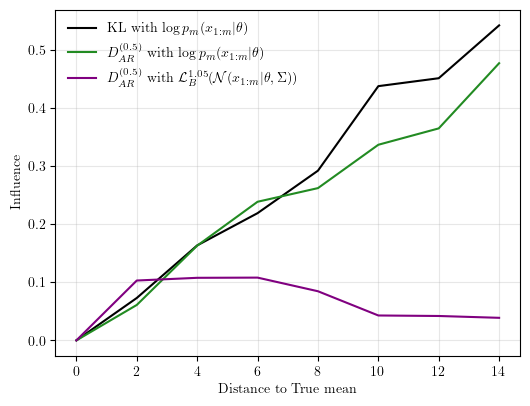

In [145]:
from scipy.interpolate import make_interp_spline, BSpline

plt.figure(figsize=(6,4.5))

# 300 represents number of points to make between T.min and T.max
xnew = np.linspace(distances.min(), distances.max(), 300) 

#spl = make_interp_spline(distances, IF.numpy(), k=3)  # type: BSpline
#power_smooth = spl(xnew)

spl2 = make_interp_spline(distances, IF_ar.numpy(), k=3)  # type: BSpline
power_smooth2 = spl2(xnew)

spl3 = make_interp_spline(distances, IF_b.numpy(), k=3)  # type: BSpline
power_smooth3 = spl3(xnew)

#plt.plot(xnew, power_smooth)
#plt.plot(xnew, power_smooth2)
#plt.plot(xnew, power_smooth3)
plt.plot(distances, IF.numpy(), label = r"KL with $\log p_m(x_{1:m}|\theta)$", color="black")#, label=r"KL with $\log p_m(x_{1:m}|\theta)$"
plt.plot(distances, IF_ar.numpy(), label=r"$D_{AR}^{(0.5)}$ with $\log p_m(x_{1:m}|\theta)$", color="forestgreen")#, label=r"$D_{AR}^{(0.5)}$ with $\log p_m(x_{1:m}|\theta)$"
plt.plot(distances, IF_b.numpy(), label=r"$D_{AR}^{(0.5)}$ with $\mathcal{L}_B^{1.05}(\mathcal{N}(x_{1:m}|\theta, \Sigma))$", color="purple")#, label=r"$D_{AR}^{(0.5)}$ with $\mathcal{L}_B^{1.05}(\mathcal{N}(x_{1:m}|\theta, \Sigma))$"

plt.legend(loc="upper left", frameon=False)
plt.xlabel("Distance to True mean")
plt.ylabel("Influence")
plt.grid(visible=True, alpha=.3)
plt.savefig('if_func.pgf', pad_inches=0)
plt.show()